# Introduction

In this notebook, we will explore the basics of lane tracking, following all the stages involved. The techniques demonstrated here are implemented as a class in the main module.

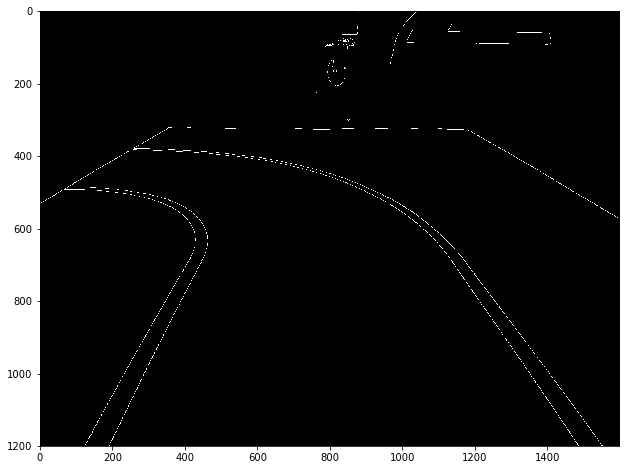

In [25]:
# Import the required libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cv2
from sklearn import linear_model

# Display wider images
%matplotlib inline 
matplotlib.rcParams["figure.figsize"] = (16.0, 8.0)


img_bgr = cv2.imread('../pics/phone2.jpeg',1)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

img_height = img_rgb.shape[0]
img_width = img_rgb.shape[1]

# # First, transform to greyscale
gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
gray = cv2.bilateralFilter(gray, 11, 17, 17)

# # Apply a Canny filter to pick out edges
edged = cv2.Canny(gray, 50, 200, apertureSize = 3)

plt.imshow(edged, cmap = "Greys_r")

In [26]:
gray.shape

(1200, 1599)

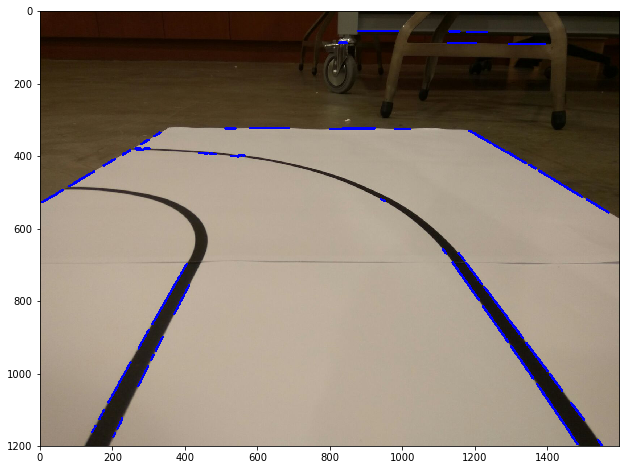

In [12]:
# Apply a probabilistic Hough transform to the image
minLineLength = 100
maxLineGap = 10
lines = cv2.HoughLinesP(edged, 1, np.pi/180, 100, minLineLength, maxLineGap)

# De-nest the list one level (for some reason, each set of points is in a nested list)
lines = list([l[0] for l in lines])

if lines is not None:
    for x1, y1, x2, y2 in lines:
        cv2.line(img_rgb, (x1, y1),(x2, y2), (0, 0, 255), 5)
    
plt.imshow(img_rgb)

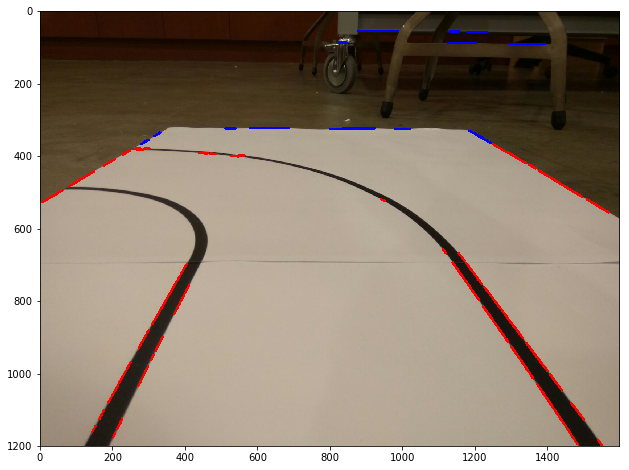

In [13]:
# Filter out those lines above the horizon
horizon_threshold = 0.3 * img_height
lines_filtered = list(filter(lambda x: x[1]>horizon_threshold and x[3] > horizon_threshold, lines))
    
    
# OPTIONAL: Filter out lines that are too close to horizontal
"""
theta_threshold = 0.25

def get_theta(x):
    x1, y1, x2, y2 = x
    return np.abs(np.arctan2((y2-y1), (x2-x1)))

lines_filtered = list(filter(lambda x: get_theta(x) > theta_threshold, lines_filtered))  # line angle with respect to horizon
"""
for x1, y1, x2, y2 in lines_filtered:
    cv2.line(img_rgb, (x1, y1),(x2, y2), (255, 0, 0), 5)

plt.imshow(img_rgb)

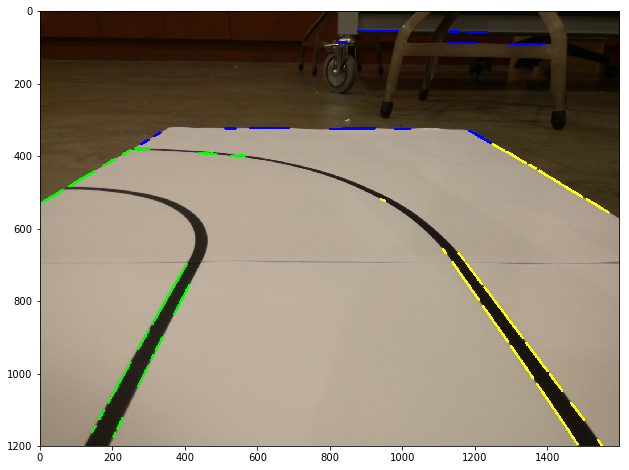

In [14]:
#Now, we will split the points up into two groups, 
# the left and the right lane, and find the equation of the line for each
centre_x = img_bgr.shape[1] / 2

# Get all the lines that have an average x value to the left of centre, and same for right
lines_left = list(filter(lambda x: (x[0] + x[2]) / 2 < centre_x, lines_filtered))
lines_right = list(filter(lambda x: (x[0] + x[2]) / 2 >= centre_x, lines_filtered))

for x1, y1, x2, y2 in lines_left:
    cv2.line(img_rgb, (x1, y1),(x2, y2), (0, 255, 0), 5)

for x1, y1, x2, y2 in lines_right:
    cv2.line(img_rgb, (x1, y1),(x2, y2), (255, 255, 0), 5)

matplotlib.rcParams["figure.figsize"] = (16.0, 8.0)
plt.imshow(img_rgb)

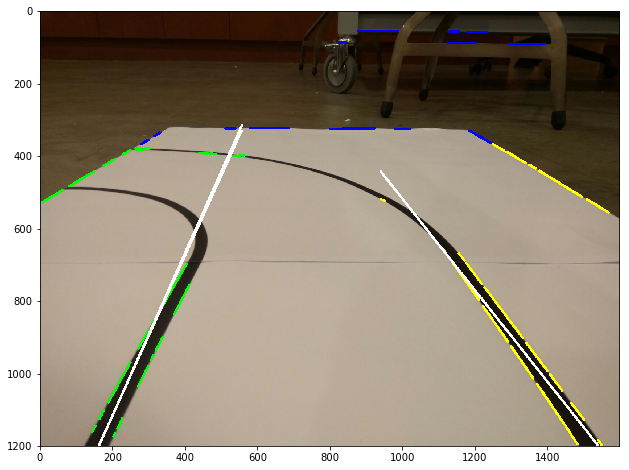

In [21]:
# Fancy list comprehension - get the elements at even positions in the sublists and flatten into one 
lines_left_x = np.transpose(np.asarray([[item for sublist in lines_left for item in sublist[0::2]]]))
lines_left_y = np.transpose(np.asarray([[item for sublist in lines_left for item in sublist[1::2]]]))

lines_right_x = np.transpose(np.asarray([[item for sublist in lines_right for item in sublist[0::2]]]))
lines_right_y = np.transpose(np.asarray([[item for sublist in lines_right for item in sublist[1::2]]]))

"""
# OPTIONAL: Fit line using Linear Regression
model = linear_model.LinearRegression()
model.fit(lines_left_x, lines_left_y)

line_x = np.arange(min(lines_left_x)[0], max(lines_left_x)[0], 50)
line_y = model.predict(line_x[:, np.newaxis])
cv2.line(img_rgb, (line_x[0], line_y[0]),(line_x[-1], line_y[-1]), (0, 255, 255), 5)

model.fit(lines_right_x, lines_right_y)
line_x2 = np.arange(min(lines_right_x)[0], max(lines_right_x)[0], 50)
line_y2 = model.predict(line_x2[:, np.newaxis])
cv2.line(img_rgb, (line_x2[0], line_y2[0]),(line_x2[-1], line_y2[-1]), (0, 255, 255), 5)  
"""

# RANSAC
model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())

# Fit the left line
model_ransac.fit(lines_left_x, lines_left_y)
m_left = model_ransac.estimator_.coef_
c_left = model_ransac.estimator_.intercept_
left_lane = (m_left, c_left)

# Draw the lines on the image, in the domain of the points of the left group
line_x = np.arange(min(lines_left_x)[0], max(lines_left_x)[0], 50)
line_y = model_ransac.predict(line_x[:, np.newaxis])
cv2.line(img_rgb, (line_x[0], line_y[0]),(line_x[-1], line_y[-1]), (255, 255, 255), 5)

# Fit the right lane
model_ransac.fit(lines_right_x, lines_right_y)
m_right = model_ransac.estimator_.coef_
c_right = model_ransac.estimator_.intercept_
right_lane = (m_right, c_right)


# Draw the lines on the image, in the domain of the points of the right group
line_x2 = np.arange(min(lines_right_x)[0], max(lines_right_x)[0], 50)
line_y2 = model_ransac.predict(line_x2[:, np.newaxis])
cv2.line(img_rgb, (line_x2[0], line_y2[0]),(line_x2[-1], line_y2[-1]), (255, 255, 255), 5)        

plt.imshow(img_rgb)

In [22]:
# Find equation of center line - first, find the intersection of the left and right lines,
# then calculate the gradient, and then sub in the gradient and the intersection to get the intercept. 
intersection_x = (c_left - c_right) / (m_right - m_left)
intersection_y = m_left * intersection_x + c_left

m_mid = np.tan((np.arctan(m_right) + np.arctan(m_left) - np.pi) / 2 ) 
c_mid = intersection_y - m_mid * intersection_x
mid_lane = (m_mid, c_mid)

print(m_left, m_mid, m_right)
print(c_left, c_mid, c_right)
print(intersection_x, intersection_y)

(array([[-2.20432305]]), array([[ 8.14893609]]), array([[ 1.26196633]]))
(array([ 1555.41541304]), array([[-5308.17804107]]), array([-742.52775854]))
(array([[ 662.94037116]]), array([[ 94.08067172]]))


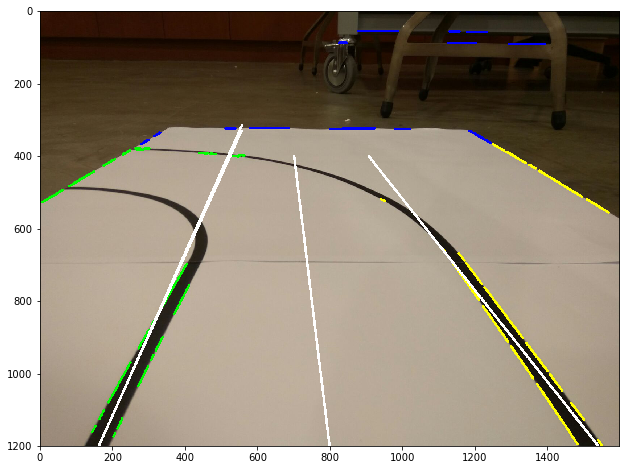

In [24]:
# Draw the lines from the bottom of the frame up to the horizon
horizon_threshold = 0.333

x_horiz_left = int((img_rgb.shape[0] * horizon_threshold - left_lane[1]) / left_lane[0])
x_bottom_left = int((img_rgb.shape[0] - left_lane[1]) / left_lane[0])
cv2.line(img_rgb, (x_horiz_left, int(img_rgb.shape[0] * horizon_threshold)), (x_bottom_left, img_rgb.shape[0]), \
         (255, 255, 255), 5)

x_horiz_right = int((img_rgb.shape[0] * horizon_threshold - right_lane[1]) / right_lane[0])
x_bottom_right = int((img_rgb.shape[0] - right_lane[1]) / right_lane[0])
cv2.line(img_rgb, (x_horiz_right,int(img_rgb.shape[0] * horizon_threshold)), (x_bottom_right, img_rgb.shape[0]), \
        (255, 255, 255), 5)                     

x_horiz_mid = int((img_rgb.shape[0] * horizon_threshold - mid_lane[1]) / mid_lane[0])
x_bottom_mid = int((img_rgb.shape[0] - mid_lane[1]) / mid_lane[0])
cv2.line(img_rgb, (x_horiz_mid, int(img_rgb.shape[0] * horizon_threshold)), (x_bottom_mid, img_rgb.shape[0]), \
        (255, 255, 255), 5) 

plt.imshow(img_rgb)